# Exercício avaliativo 3 - Algoritmo de Metropolis 2
## Introdução a Física Estatística e Computacional

Luís Felipe Ramos Ferreira - 2019022553

Igor Lacerda Faria da Silva - 2020041973

Gabriel Rocha Martins - 2019006639

In [2]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [3]:
from numpy.typing import NDArray

In [4]:
import matplotlib.gridspec as gridspec

In [5]:
@jit(nopython=True)
def vizinhos(N: int):
    # Define a tabela de vizinhos
    L = int(np.sqrt(N))
    viz = np.zeros((N, 4), dtype=np.int16)
    for k in range(N):
        viz[k, 0] = k + 1
        if (k + 1) % L == 0:
            viz[k, 0] = k + 1 - L
        viz[k, 1] = k + L
        if k > (N - L - 1):
            viz[k, 1] = k + L - N
        viz[k, 2] = k - 1
        if k % L == 0:
            viz[k, 2] = k + L - 1
        viz[k, 3] = k - L
        if k < L:
            viz[k, 3] = k + N - L
    return viz

In [6]:
@jit(nopython=True)
def algoritmo_de_metropolis(L: int, T: float, passos: int):
    energia: np.ndarray = np.zeros(passos, dtype=np.int32)
    magnetização: np.ndarray = np.zeros(passos, dtype=np.int32)

    spins: np.ndarray = np.array([-1, 1], dtype=np.int8)

    variações_de_energia = np.array([8.0, 4.0, 0.0, -4.0, -8.0], dtype=np.float64)
    expoentes = np.exp(variações_de_energia / T)

    N = L * L
    S = np.random.choice(spins, N)

    viz = vizinhos(N)

    for i in range(passos):
        for k in np.arange(N):
            índice = int(S[k] * np.sum(S[viz[k]]) * 0.5 + 2)
            if np.random.rand() < expoentes[índice]:
                S[k] = -1 * S[k]
        energia[i] = -np.sum(S * (S[viz[:, 0]] + S[viz[:, 1]]))
        magnetização[i] = np.sum(S)

    return energia, magnetização

In [7]:
@jit(nopython=True)
def calor_específico(T: float, N: int, E: NDArray) -> NDArray:
    return (np.average(np.power(E, 2)) - np.power(np.average(E), 2)) / (
        N * np.power(T, 2)
    )

In [8]:
@jit(nopython=True)
def suscetibilidade_magnética(T: float, N: int, M: NDArray) -> NDArray:
    return (np.average(np.power(M, 2)) - np.power(np.average(M), 2)) / (N * T)

In [9]:
@jit(nopython=True)
def calcula_erro(arr: NDArray) -> float:
    return np.sqrt(
        np.sum(np.power(arr - np.average(arr), 2)) / (arr.size * (arr.size - 1))
    )

In [10]:
# TODO: tentar botar numba
def calcula_métricas(
    passo: int,
    seguro: int,
    passosDeMC: int,
    temperatura: float,
    numSpins: int,
    energias: NDArray[np.float64],
    magnetizações: NDArray[np.float64],
):
    magnetizações_mod = np.abs(magnetizações)
    energias_att: np.ndarray = np.array([energia[seguro:] for energia in energias])
    magnetizações_att = np.array(
        [magnetização[seguro:] for magnetização in magnetizações_mod]
    )
    batches = int((passosDeMC - seguro) / passo)
    tensor = np.zeros((N, batches, 4))
    for i in range(N):
        for j in range(0, passosDeMC - seguro, passo):
            cal = calor_específico(
                temperatura, numSpins, energias_att[i][j : j + passo]
            )
            sus = suscetibilidade_magnética(
                temperatura, numSpins, magnetizações_att[i][j : j + passo]
            )
            ene = np.average(energias_att[i][j : j + passo]) / numSpins
            mag = np.average(magnetizações_att[i][j : j + passo]) / numSpins
            tensor[i][int(j / passo)] = np.array([cal, sus, ene, mag])

    erros = np.zeros((N, 4))
    for i, matrix in enumerate(tensor):
        erro_cal = calcula_erro(matrix[:, 0])
        erro_sus = calcula_erro(matrix[:, 1])
        erro_ene = calcula_erro(matrix[:, 2])
        erro_mag = calcula_erro(matrix[:, 3])
        erros[i] = np.array([erro_cal, erro_sus, erro_ene, erro_mag])

    novas = [np.average(matrix, axis=0) for matrix in tensor]

    return novas, erros

In [11]:
N = 1
PARTIÇÃO = 1000
temperaturas = np.linspace(0.4, 3, 20)
comprimentos = np.linspace(32, 100, 5, dtype=int)
NÚMERO_DE_SEGURANÇA = 5000
PASSOS_DE_MONTECARLO = 15000
energias = np.zeros((N, PASSOS_DE_MONTECARLO))
magnetizações = np.zeros((N, PASSOS_DE_MONTECARLO))
temperaturas = np.linspace(0.4, 3, 20)
métricas = np.zeros((temperaturas.size, N, 4), dtype=np.float64)
erros = np.zeros((temperaturas.size, 4), dtype=np.float64)

In [12]:
def plot_por_comprimento(comprimento: int):
    NÚMERO_DE_SPINS = np.power(comprimento, 2)
    for i, t in enumerate(temperaturas):
        for j in range(N):
            energias[j], magnetizações[j] = algoritmo_de_metropolis(
                comprimento, t, PASSOS_DE_MONTECARLO
            )
        métricas[i], erros[i] = calcula_métricas(
            PARTIÇÃO,
            NÚMERO_DE_SEGURANÇA,
            PASSOS_DE_MONTECARLO,
            t,
            NÚMERO_DE_SPINS,
            energias,
            magnetizações,
        )
    titulos = [
        "Calor Específico",
        "Suscetibilidade Magnética",
        "Energias",
        "Magnetizações",
    ]
    fig = plt.figure(figsize=(10, 20))
    gs = gridspec.GridSpec(4, 1, figure=fig)
    for i in range(4):
        ax = fig.add_subplot(gs[i])
        ax.set_title(f"{titulos[i]} {comprimento}")
        ax.set_ylabel(titulos[i])
        ax.set_xlabel("Temperatura")
        ax.errorbar(
            x=temperaturas,
            y=métricas[:, 0][:, i],
            yerr=erros[:, i],
            fmt="o",
            markersize=1,
            ecolor="red",
            color="blue",
        )

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.savefig(f"{comprimento}-métricas.png")
    plt.show()

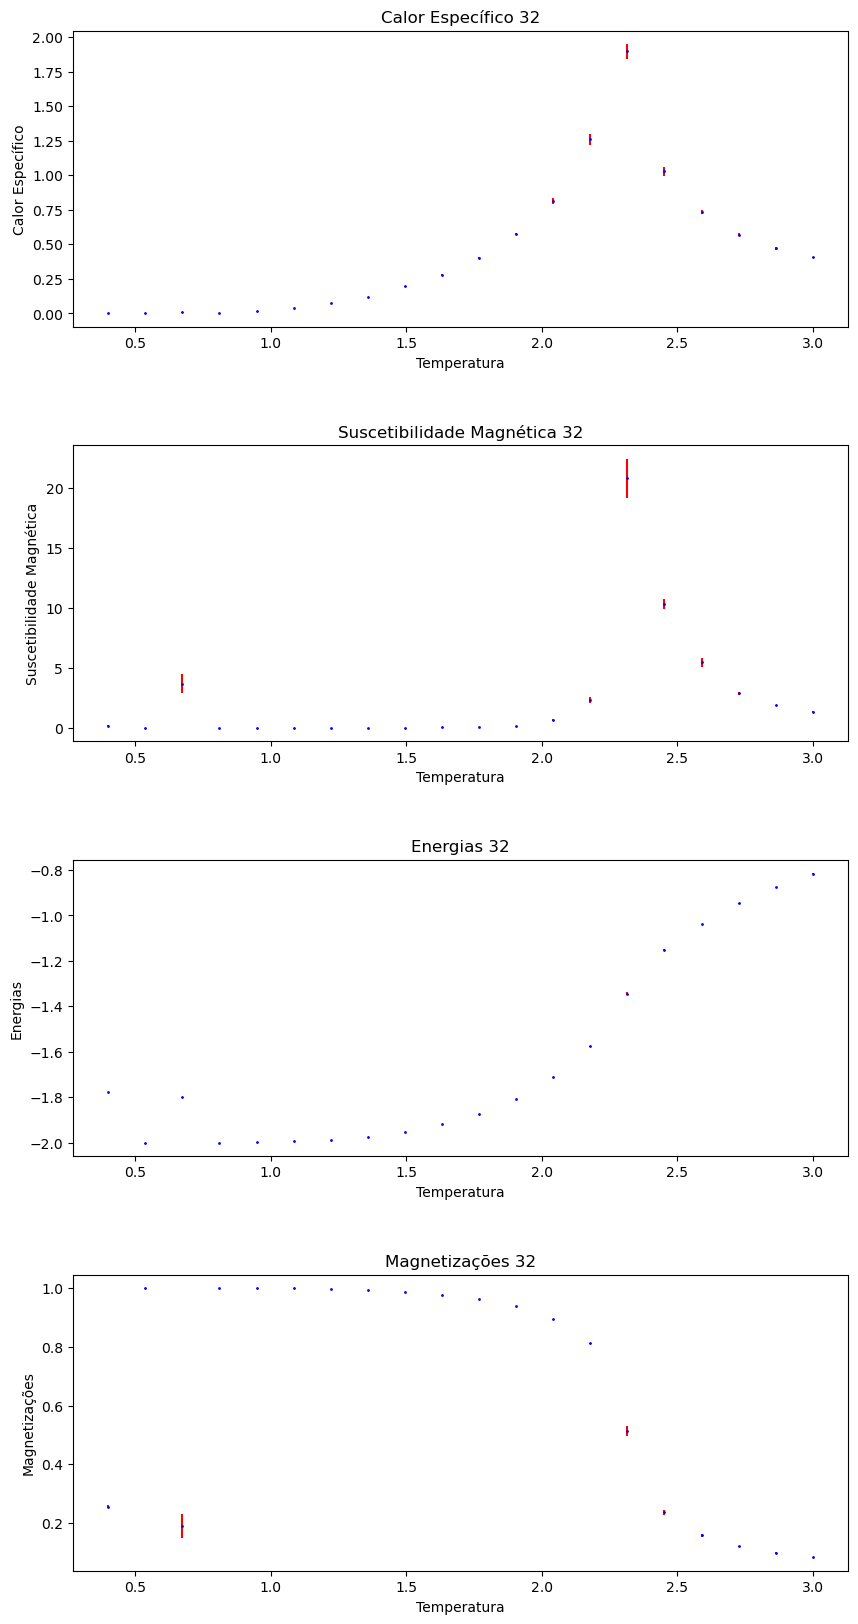

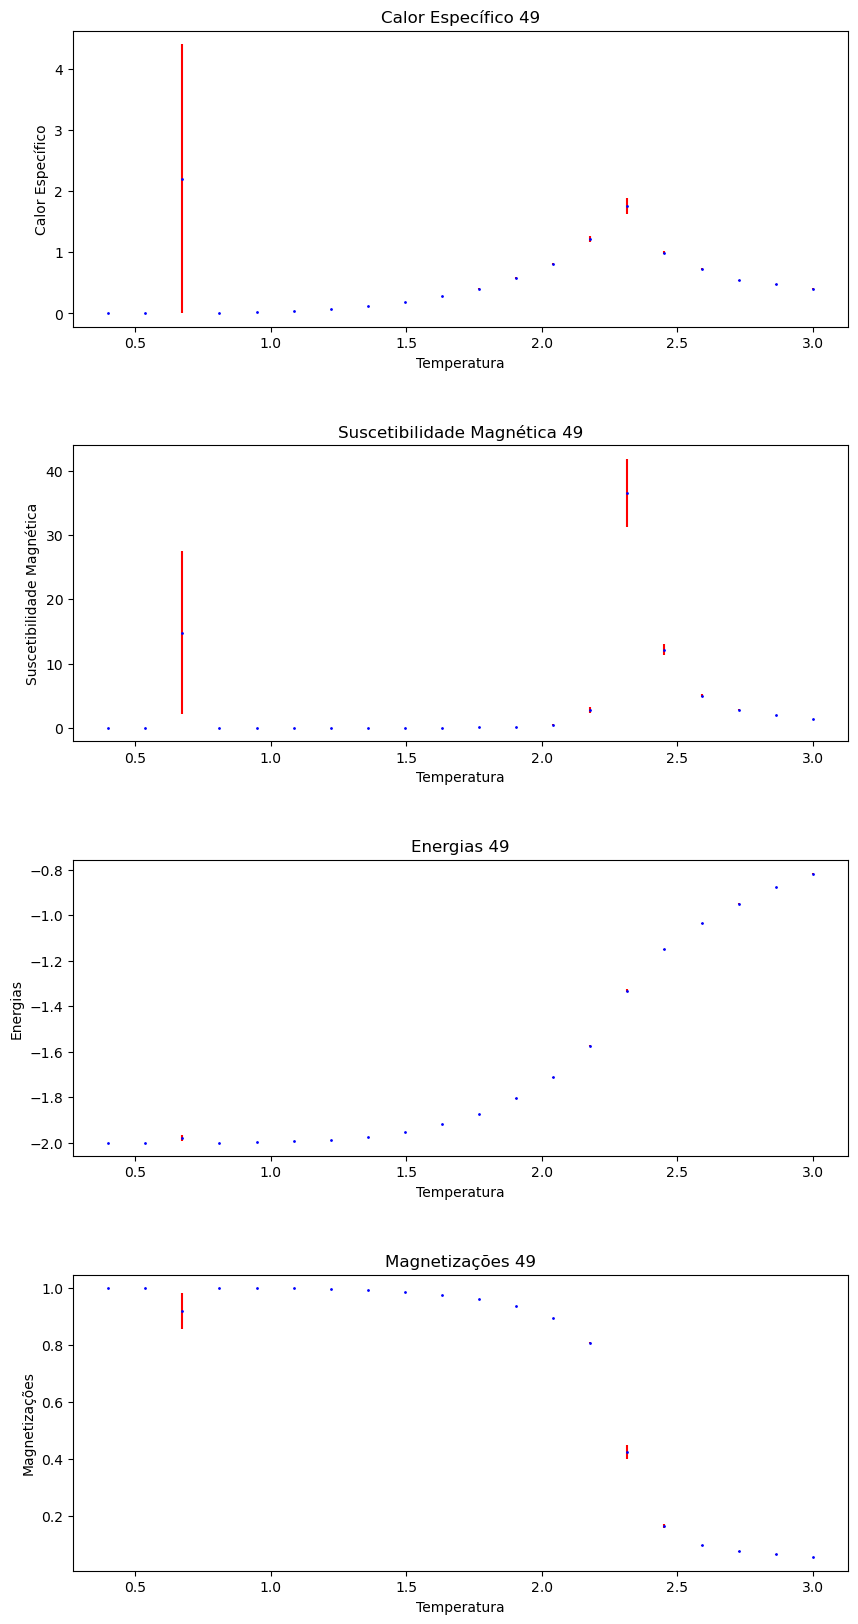

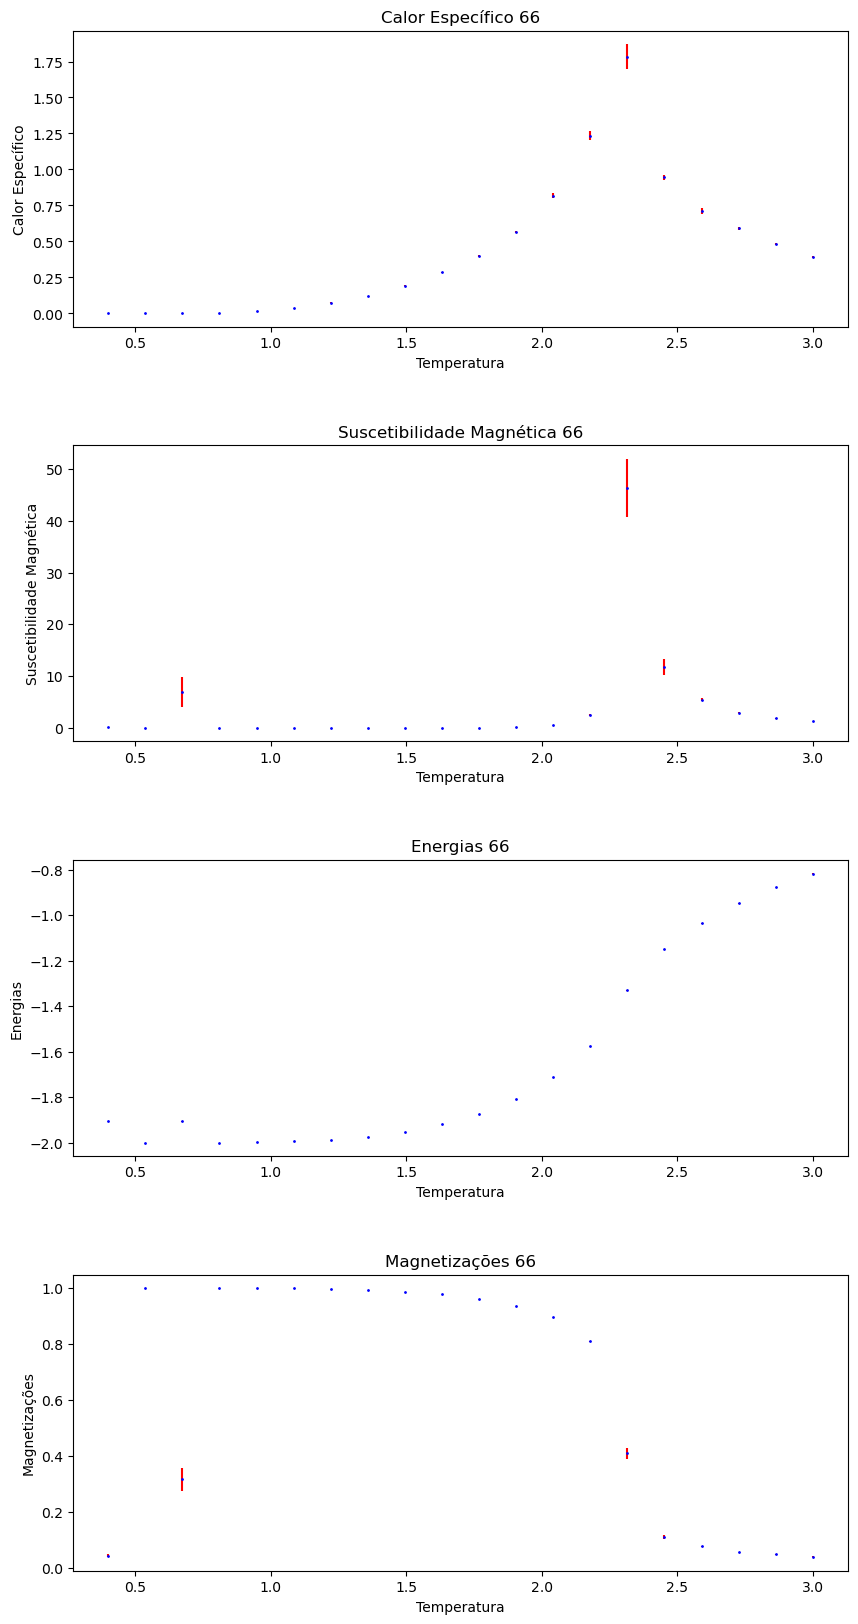

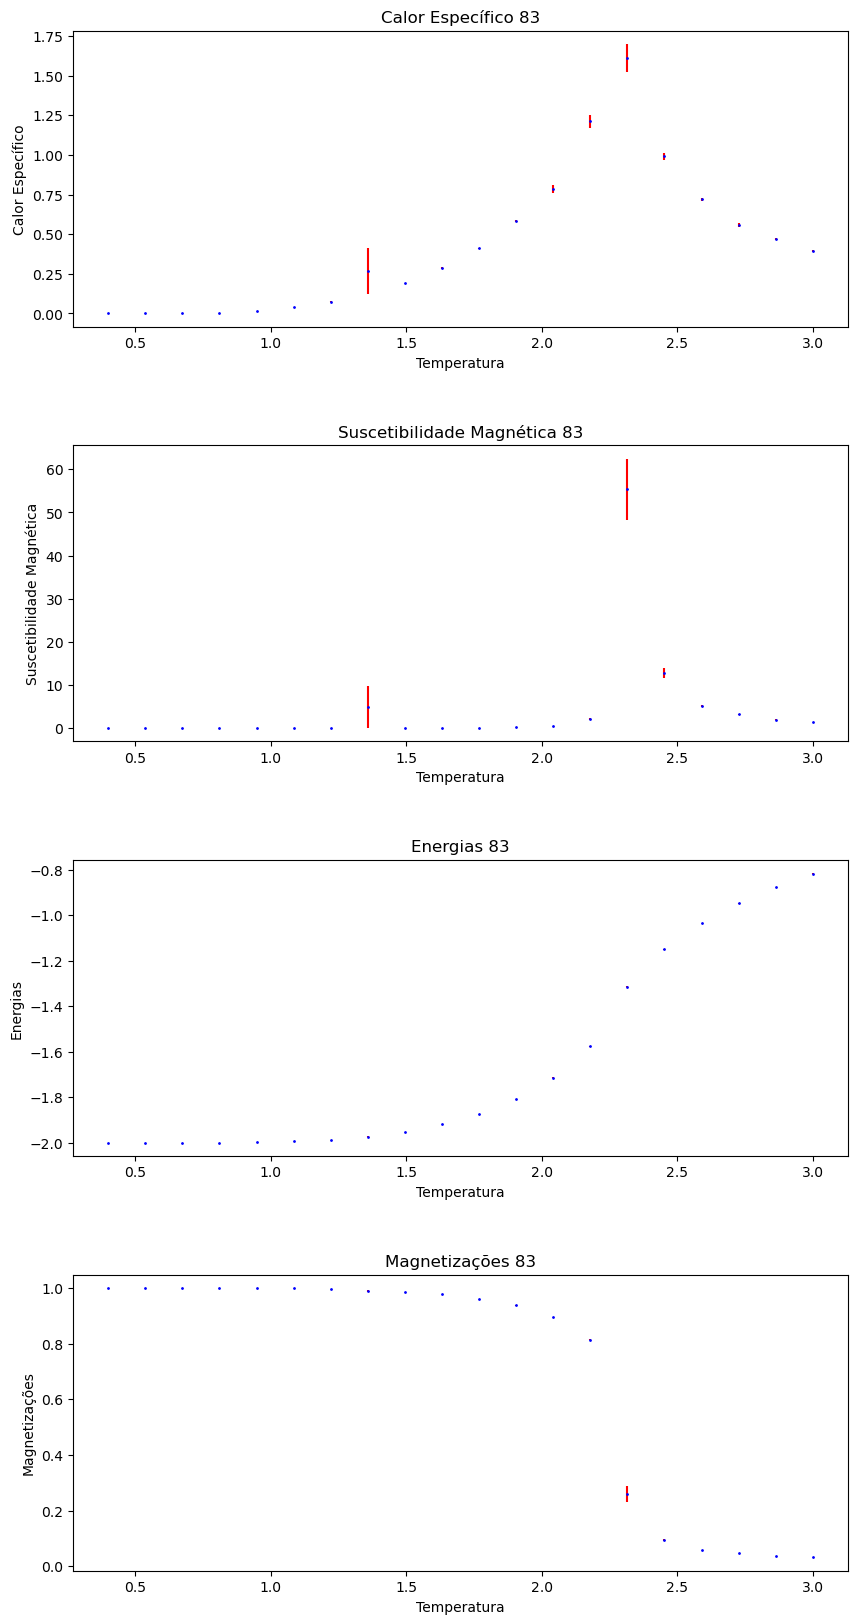

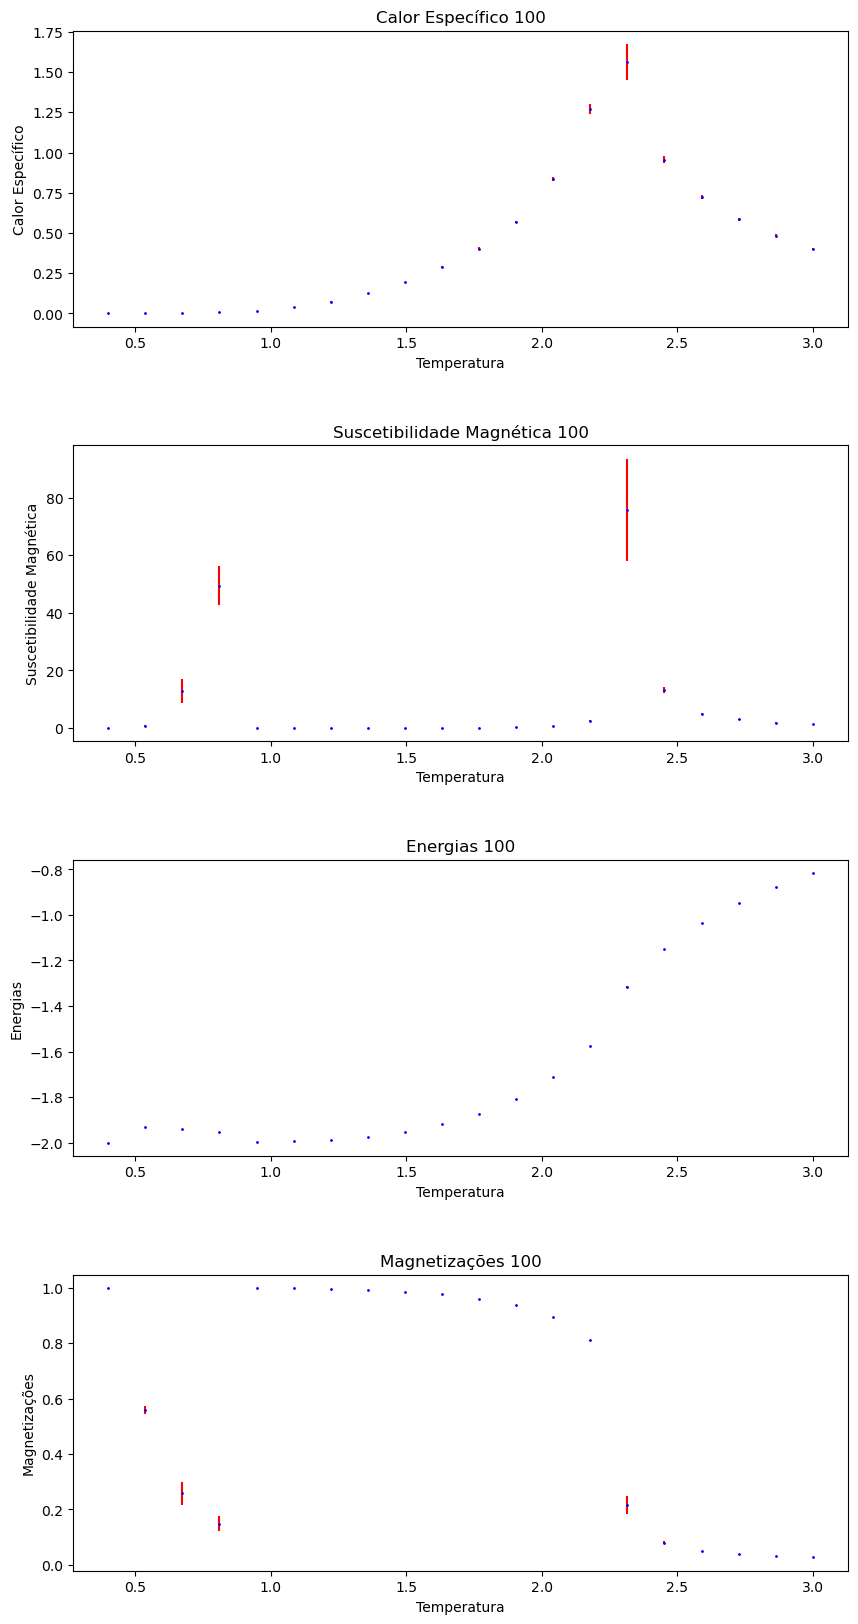

In [13]:
for comprimento in comprimentos:
    plot_por_comprimento(comprimento)

1. A escolha dos parâmetros descritos foi feita com base no que nós decidimos como as melhores combinações para obter resultados de forma rápida, eficiente e correta. Escolhemos um número de passos para a termalização de 5000, de modo que este se mostrou um valor seguro para que os sistemas analisados entrem em convergência. O número de passos de Monte Carlo utilizado para calcular as médias termodinâmicas foi 10000, enquanto o número de partições de cada um desses passos escolhido foi 1000. Com estes valores, acreditamos que teríamos uma boa qualidade no cálculo das médias do calor específico e da susceptibilidade magnética, já que teríamos estes valores calculados 10 vezes. O tamanho da partição foi escolhido principalmente pela facilidade de se trabalhar com o número 1000, fora o fato de que se trata de um valor grande o suficiente para se obter bons resultados. 
Inicialmente, optamos por um número de passos de Monte Carlo para o cálculo das médias de 5000 e um número de passos de Monte Carlo para termalização de 2000. No entanto, acreditamos que, embora estes valores tenham apresentado alguns resultados interessantes, 2000 passos não seria uma quantidade segura para garantir a convergência do sistema, assim como 5000 passos para calcular as médias pudesse prejudicar a obtenção de valores que realmente descrevessem o sistema como um todo.

    Por fim, em relação à temperatura e ao tamanho do sistema, nós optamos por gerar e analisar gráficos para diferentes valores escolhidos. Mais especificamente, geramos 20 valores uniformemente distribuídos de temperatura, entre 0.4 e 3.0 (como definido no enunciado do exercício anterior), e para rede geramos 5 valores uniformemente distribuídos entre 32 e 100 (também como definido no exercício anterior). Essa quantidade de valores para tempreatura foi escolhida para que os gráficos gerados tivessem uma visualização mais completa da curva de variação das métricas, de modo que o custo computacional para gerá-los não fosse um gargálo. A quantidade de tamanhos da rede, por sua vez, foi escolhida para que pudéssemos analisar como essa variável afetaria o sistema, sem que fosse necessário gerar uma quantidade exorbitante de gráficos/imagens que poderiam poluir e prejudicar as interpretações do sistema, enquanto não fosse perdida muita informação sobre ele.

2. A variação das grandezas em função do aumento da temperatura é nítido, e analisamos o seguinte para cada uma delas:
    - <u>Energia</u>: a energia, como esperáva-se, aumento com o aumento da temperatura do sistema. Mais especificamente, para cada gráfico gerado, notamos que a energia converge para valores maiores com o aumento da tempreatura, em um formato muito similar ao de uma curva logística. A energia parece variar sempre entre valores de -2.0 e -0.7, aproximadamente (para as configurações analisadas).
    - <u>Magnetização</u>: a magnetização, também como esperado, diminui com o aumento da temperatura do sistema. De forma similar (mas não igual) a energia, sua diminuição aparenta seguir a forma de uma curva logística, só que inversa. Os valores calculados para as configurações escolhidas mostram que a magnetização varia entre 0 e 1.
    - <u>Calor específico</u>: o calor específico, por sua vez, parece aumentar junto com o aumento da tempratura até atingir um pico, a partir do qual passa a decair com o aumento da temperatura. Esse pico ocorre em um ponto constante para todos os tamanhos de rede analisados: um valor de temperatura muito próximo à 2.3. Em algumas configurações, um ponto de tempreatura próximo à 0.7 também foi um ponto de pico local, onde o calor específico aumento até chegar nele e posteriormente decaiu até certo ponto.
    - <u>Susceptibilidade magnética</u>: a susceptibilidade magnética se comportou de forma extremamente similar ao calor específico, embora alguns picos locais, fora o pico global próximo ao ponto de tempratura 2.7, tenham sido bem mais frequentes. Além disso, as curvas feitas pela susceptibilidade magnética foram bem neos suaves do que as do calor específico, com saltos muito grandes entre um valor e outro.

    AQUI TEM QUE FALAR MAIS

3. Em relação à variação dos tamanhos da rede, pudemos analisar o seguinte em relação aos gráficos gerados;
    - <u>Energia</u>: a energia do sistema se comportou de forma praticamente idêntica em todas as configurações de tamanho de rede feitos. O gráfico se manteve no formato de uma curva logística e sempre variando entre valores de energia de 0.8 e 2.0 aproximadamente.
    - <u>Magnetização</u>: para a magnetização, o comportamente foi extremamente similar ao da energia, e os gráficos gerados se comportaram sempre como uma curva logística inversa, variando de 1 até 0. É importante observar que, para ambas energia e magnetização, o ponto de inflexão dos gráficos gerados ficou sempre próximo do ponto onde a temperatura é aproximadamente 2.3. Este ponto, como será discutido posteriormente, parece ser o ponto a aprtir do qual o sistema muda seu comportamento.
    - <u>Calor específico</u>: o calor específico teve formatos de gráficos gerados se comportando da mesma maneira para basicamente todas as configurações de tamanhos de rede, com o ponto onde a métrica deixa de aumentar e passa a decair por volta da temperatura ponto 2.3. Os valores do calor específico variam entre 0 e 1.75, com o pico estando no ponto especial citado. Para a configuração de tamanho de rede igual a 49, mais especificamente, houve um *outliar* por volta da temperatura 0.7. Não conseguimos interpretar exatamente por quẽ isso ocorreu, embora seja algoa  ser analisado e estudado.
    - <u>Susceptibilidade magnética</u>: a susceptibilidade magnética é a variável mais afetada em valor escalar pelo aumento da rede. Nota-se que, com esse aumento, a métrica também se torna maior. O comportamento do seu gráfico segue o mesmo do calor específico.
        

4. Em relação aos erros estatísticos, alguns *insights* interessantes podem ser feitos.